In [10]:
import suite2p
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

Set up settings for suite2p. Suite2p documentation says that all settings can be set in both the ops parameter and db parameter (no funcitonal difference), but the db parameter will override the ops parameter. For this reason, they suggest using the ops parameter to set settings that you want for every analysis, while the db parameter should be used for data-specific parameters (such as the data path).

In [2]:
ops = suite2p.default_ops()
ops['tau'] = 1.3
ops['fs'] = 8.3091
db = {
    'data_path': ['./tiffs/'],
    'tiff_list': ['scanMovieOneFieldAllFrames.tiff']
}
db

{'data_path': ['./tiffs/'], 'tiff_list': ['scanMovieOneFieldAllFrames.tiff']}

We can run the entire algorithm in one step. There are likely more settingd we can fine-tune, but we will run with close to default settings for now. We also can run each of the steps individually, if desired, by using the detection_wrapper, registration_wrapper, etc. methods

In [3]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['./tiffs/'], 'tiff_list': ['scanMovieOneFieldAllFrames.tiff']}
FOUND BINARIES AND OPS IN ['./tiffs/suite2p/plane0/ops.npy']
removing previous detection and extraction files, if present
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: ./tiffs/suite2p/plane0/data.bin
NOTE: Applying builtin classifier at /src/s2p-lbm/suite2p/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 12
Binned movie of size [5143,234,232] created in 65.37 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 4.29, threshold 21.43 
0 ROIs, score=439.11
1000 ROIs, score=67.75
2000 ROIs, score=32.70
Detected 2933 ROIs, 93.52 sec
After removing overlaps, 2241 ROIs remain
----------- Total 163.64 sec.
----------- EXTRACTION
Masks created, 2.09 sec.
Extracted fluorescence from 2241 ROIs in 61717 frames, 68.82 sec.
----------- Total 73.90 sec.
----------- CLASSIFICATION
['compact', 'npi

Plot results from the registration

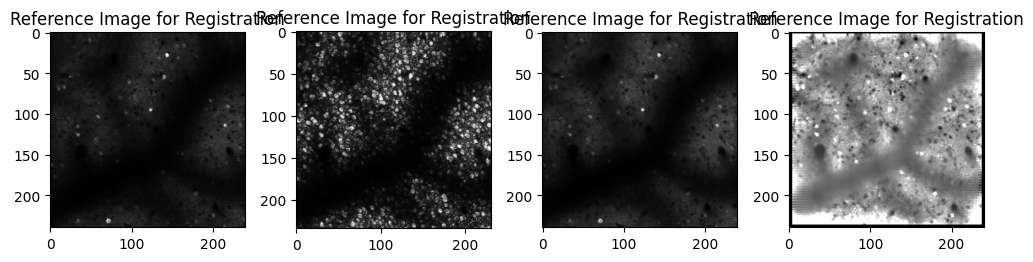

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(output_ops['refImg'], cmap='gray')
plt.title('Reference Image for Registration')

plt.subplot(1,4,2)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title('Registered Image, Max Projection')

plt.subplot(1,4,3)
plt.imshow(output_ops['meanImg'], cmap='gray')
plt.title('Mean registered image')

plt.subplot(1,4,4)
plt.imshow(output_ops['meanImgE'], cmap='gray')
plt.title('High-pass filtered mean registered image')

plt.tight_layout()

Load in the results from suite2p and plot. Note: the default plotting method plots the binary masks, which is why they look strange

In [11]:
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:,0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape

((2241,), (2241,))

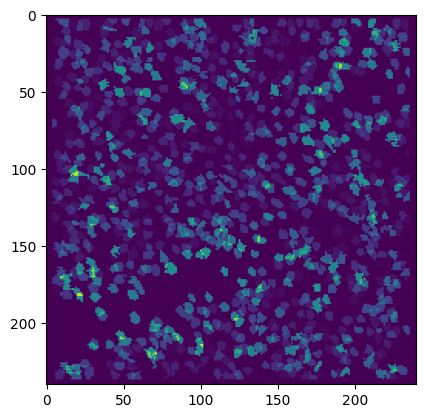

In [16]:
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=output_ops['Ly'], Lx=output_ops['Lx'], label_id=True)
plt.imshow(im[iscell,:,:].sum(axis=0))

Load in the traces and plot some representative traces

In [17]:
f_cells = np.load(Path(output_ops['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(output_ops['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_ops['save_path']).joinpath('spks.npy'))   
f_cells.shape, f_neuropils.shape, spks.shape

((2241, 61717), (2241, 61717), (2241, 61717))

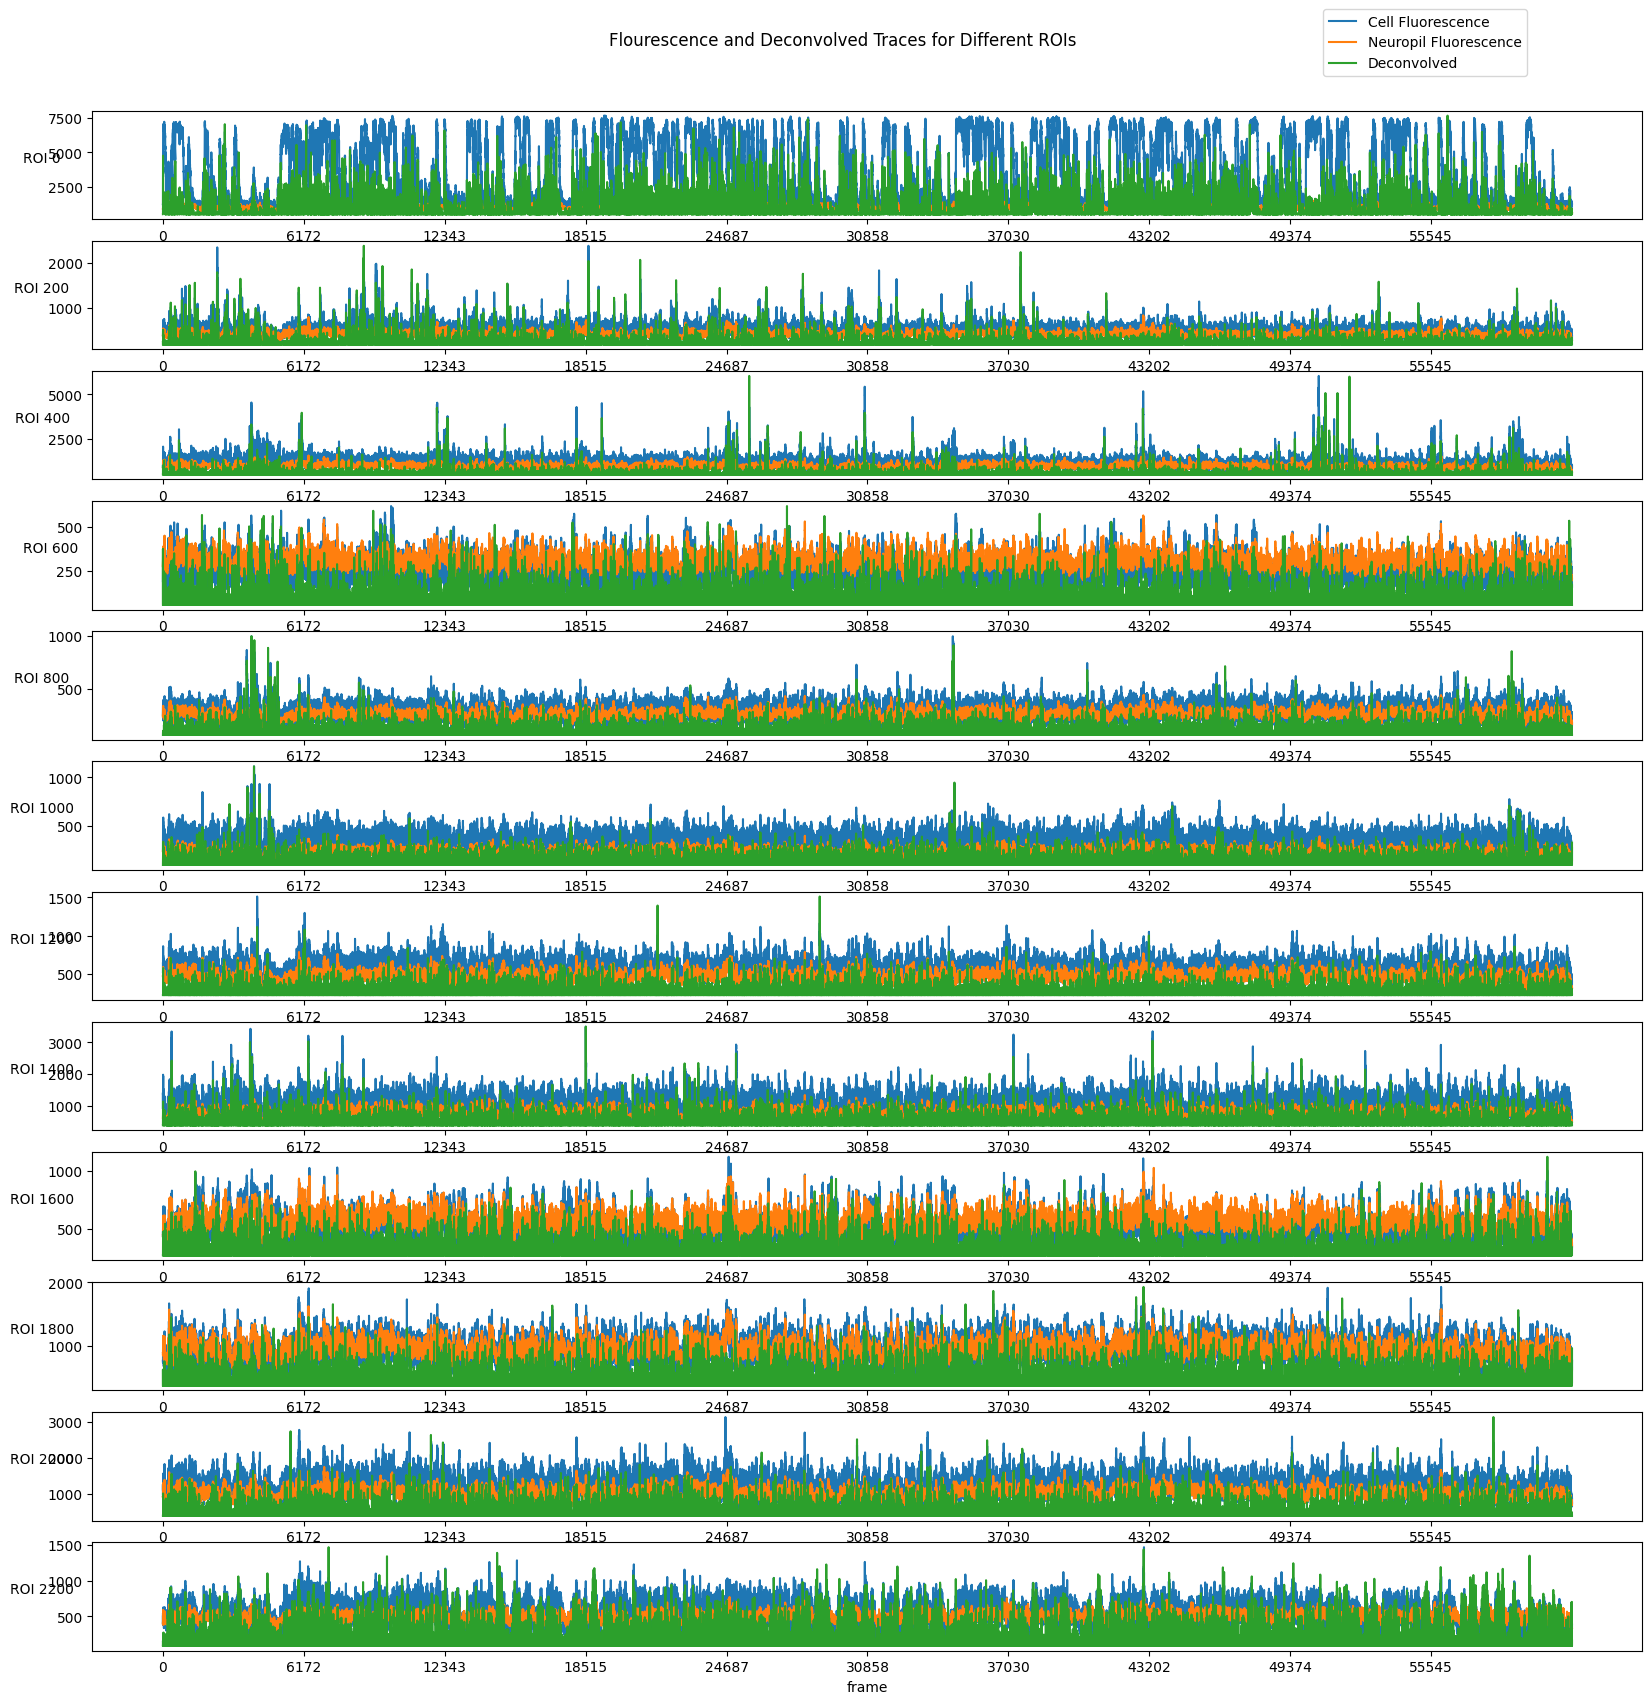

In [18]:
plt.figure(figsize=[20,20])
plt.suptitle("Flourescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(f_cells))[::200]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin 
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))

Plot example of mask, surrounded by its neuropil mask (all of this is binary)

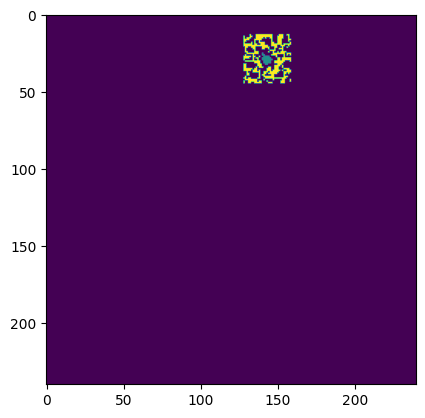

In [19]:
nmask_ind = stats[0]['neuropil_mask']
nmask = np.zeros(240*240)
nmask[nmask_ind] = 2
nmask = nmask.reshape(240,240)
plt.imshow(nmask + im[0])

In [20]:
# this is where all outputs are saved
output_ops['save_path']

'./tiffs/suite2p/plane0'

/tmp/ipykernel_1121/2009204446.py:8: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im, axis=0), cmap='jet')
/tmp/ipykernel_1121/2009204446.py:12: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
/tmp/ipykernel_1121/2009204446.py:16: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')


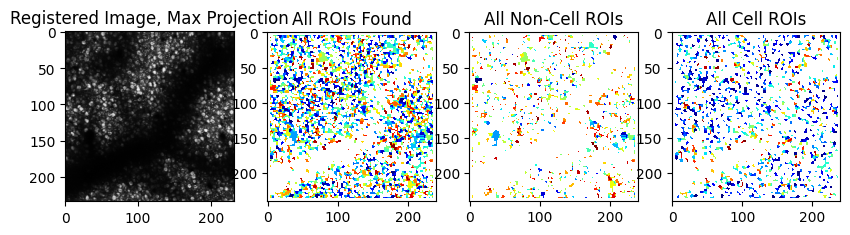

In [22]:
# continue with more plots demonstrating results of segmentation

im[im == 0] = np.nan
plt.figure(figsize=(10,10))
plt.subplot(1, 4, 1)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 2)
plt.imshow(np.nanmax(im, axis=0), cmap='jet')
plt.title("All ROIs Found")

plt.subplot(1, 4, 3)
plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
plt.title("All Non-Cell ROIs")

plt.subplot(1, 4, 4)
plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
plt.title("All Cell ROIs");